# Дмитрий Ильин
# Модуль 3. Мультимодальные и мультизадачные модели. Часть 1.

Это первая часть домашней работы №3 "Реализация Visual Question Answering / Document Question Answering"

## Часть 1.Обучение модели для задачи Document Question Answering [2 балла]

**Цель:** отработать навыки работы с мультимодальностью на задаче Document Question Answering.

В этой части задания вам предстоит ознакомиться с обучением модели Document Question Answering. Вы можете пропустить эту часть и начать делать уже следующую, для них уже есть обученная готовая модель. Тут вам нужно лишь пройти по ноутбуку и посмотреть на процесс обучения. Он может занять продолжительное время.

---
**В каком виде прислать результат**.

Заполненный jupyter-notebook и графики обучения модели (можно прислать ссылку на wandblogger/mlflow)

**Ожидаемый результат**

В качестве результатов в этой части вам нужно представить обученную модели и показать результаты её работы, посчитав долю правильных ответов на вопросы.



In [1]:
# Раскомментируйте

#!pip install transformers[torch]
#!pip install accelerate -U
#!pip install datasets
#!pip install evaluate
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'

#!sudo apt install tesseract-ocr
#!pip install -q pytesseract

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
import evaluate

metric = evaluate.load("squad_v2")

In [4]:
import torch

In [5]:
from datasets import load_dataset, load_from_disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root_path = "/content/drive/My Drive/MIPT/ML Models/HW3/"

# Задача ответов на вопросы в документе

Задача ответов на вопросы по документу, также называемая визуальными ответами на вопросы по документу, — это задача, которая включает в себя предоставление ответов на вопросы об изображениях документов. Входные данные для моделей, поддерживающих эту задачу, обычно представляют собой комбинацию изображения и вопрос, а результатом является ответ, выраженный на естественном языке. Эти модели используют несколько модальностей, в том числе текст, положение слов (ограничивающие рамки) и само изображение.

В этом руководстве показано, как:

- Дообучать [LayoutLMv2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2) в [наборе данных DocVQA](https://huggingface.co/datasets/nielsr/docvqa_1200_examples_donut).
- Использовать свою тонко настроенную модель для вывода.

<Tip>

Задача, проиллюстрированная в этом руководстве, поддерживается следующими архитектурами моделей:

<!--Этот совет генерируется автоматически командой make fix-copies, не заполняйте вручную!-->

[LayoutLM](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlm), [LayoutLMv2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2), [LayoutLMv3](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv3)

LayoutLMv2 решает задачу ответов на вопросы в документе, добавляя заголовок ответа на вопрос поверх конечных скрытых состояний токенов, чтобы предсказать положения начальных и конечных токенов ответа. Другими словами, проблема рассматривается как экстрактивный ответ на вопрос: учитывая контекст, извлеките, какая часть информации отвечает на вопрос. Контекст получается из результатов работы механизма OCR, здесь это Tesseract от Google.

Прежде чем начать, убедитесь, что у вас установлены все необходимые библиотеки. LayoutLMv2 зависит от detectron2, torchvision and tesseract.

```bash
pip install -q transformers datasets
```

```bash
pip install 'git+https://github.com/facebookresearch/detectron2.git'
pip install torchvision
```

```bash
sudo apt install tesseract-ocr
pip install -q pytesseract
```

После установки всех зависимостей перезапустите среду выполнения.

Мы рекомендуем вам поделиться своей моделью с сообществом. Войдите в свою учетную запись Hugging Face, чтобы загрузить его в 🤗 Hub.
При появлении запроса введите свой токен для входа:

Давайте определим некоторые глобальные переменные.

In [7]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 4

## Загрузка данных

В этом руководстве мы используем небольшой образец предварительно обработанного DocVQA, который вы можете найти на 🤗 Hub. Если вы хотите использовать полный набор данных DocVQA, вы можете зарегистрировать и загрузить его на [DocVQA](https://rrc.cvc.uab.es/?ch=17). Если вы это сделаете, чтобы продолжить работу с этим руководством, ознакомьтесь с [как загрузить файлы в набор данных 🤗](https://huggingface.co/docs/datasets/loading#local-and-remote-files).

In [8]:
dataset = load_dataset("nielsr/docvqa_1200_examples")
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 200
    })
})

Как видите, датасет уже разделен на обучающий и тестовый наборы. Взгляните на случайный пример, чтобы ознакомиться с признаками.

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'query': {'de': Value(dtype='string', id=None),
  'en': Value(dtype='string', id=None),
  'es': Value(dtype='string', id=None),
  'fr': Value(dtype='string', id=None),
  'it': Value(dtype='string', id=None)},
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), length=-1, id=None),
 'answer': {'match_score': Value(dtype='float64', id=None),
  'matched_text': Value(dtype='string', id=None),
  'start': Value(dtype='int64', id=None),
  'text': Value(dtype='string', id=None)}}

Вот что представляют собой отдельные поля:
* `id`: идентификатор примера
* `image`: объект PIL.Image.Image, содержащий изображение документа.
* `query`: строка вопроса - вопрос, заданный на естественном языке, на нескольких языках.
* `answers`: список правильных ответов, предоставленных комментаторами-людьми.
* `words` и `bounding_boxes`: результаты OCR, которые мы здесь использовать не будем
* `answer`: ответ, соответствующий другой модели, которую мы здесь не будем использовать.

Давайте оставим только вопросы на английском языке и удалим признак `answer`, который, по всей видимости, содержит прогнозы другой модели.
Мы также возьмем первый из ответов из набора, предоставленного аннотаторами. Альтернативно, вы можете выбрать его случайным образом.

In [ ]:
updated_dataset = dataset.map(lambda example: {"question": example["query"]["en"]}, remove_columns=["query"])
updated_dataset = updated_dataset.map(
    lambda example: {"answer": example["answers"][0]}, remove_columns=["answer", "answers"]
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Обратите внимание, что чекпоинт LayoutLMv2, который мы используем в этом руководстве, был обучен с помощью `max_position_embeddings = 512` (вы можете найти эту информацию в [файле `config.json` чекпоинта](https://huggingface.co/microsoft/layoutlmv2-base-uncased/blob/main/config.json#L18)).
Мы можем урезать примеры, но чтобы избежать ситуации, когда ответ может находиться в конце большого документа и в конечном итоге быть усеченным, здесь мы удалим несколько примеров, в которых вложение может оказаться длиннее 512.
Если большинство документов в вашем наборе данных длинные, вы можете реализовать стратегию скользящего окна — подробности см. в [этот блокнот](https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb).

In [ ]:
updated_dataset = updated_dataset.filter(lambda x: len(x["words"]) + len(x["question"].split()) < 512)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

На этом этапе давайте также удалим признаки OCR(оптическое распознавание символов) из этого набора данных. Это результат OCR для тонкой настройки другой модели. Если бы мы захотели их использовать, они все равно потребовали бы некоторой обработки, поскольку они не соответствуют входным требованиям модели, которую мы используем в этом руководстве. Вместо этого мы можем использовать [LayoutLMv2Processor](https://huggingface.co/docs/transformers/main/en/model_doc/layoutlmv2#transformers.LayoutLMv2Processor) для исходных данных как для OCR, так и для токенизации. Таким образом, мы получим входные данные, соответствующие ожидаемым входным данным модели. Если вы хотите обрабатывать изображения вручную, ознакомьтесь с [документацией модели `LayoutLMv2`](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2), чтобы узнать, какой формат ввода модель ожидает.

In [ ]:
updated_dataset = updated_dataset.remove_columns("words")
updated_dataset = updated_dataset.remove_columns("bounding_boxes")

Наконец, исследование данных не будет полным, если мы не взглянем на пример изображения.

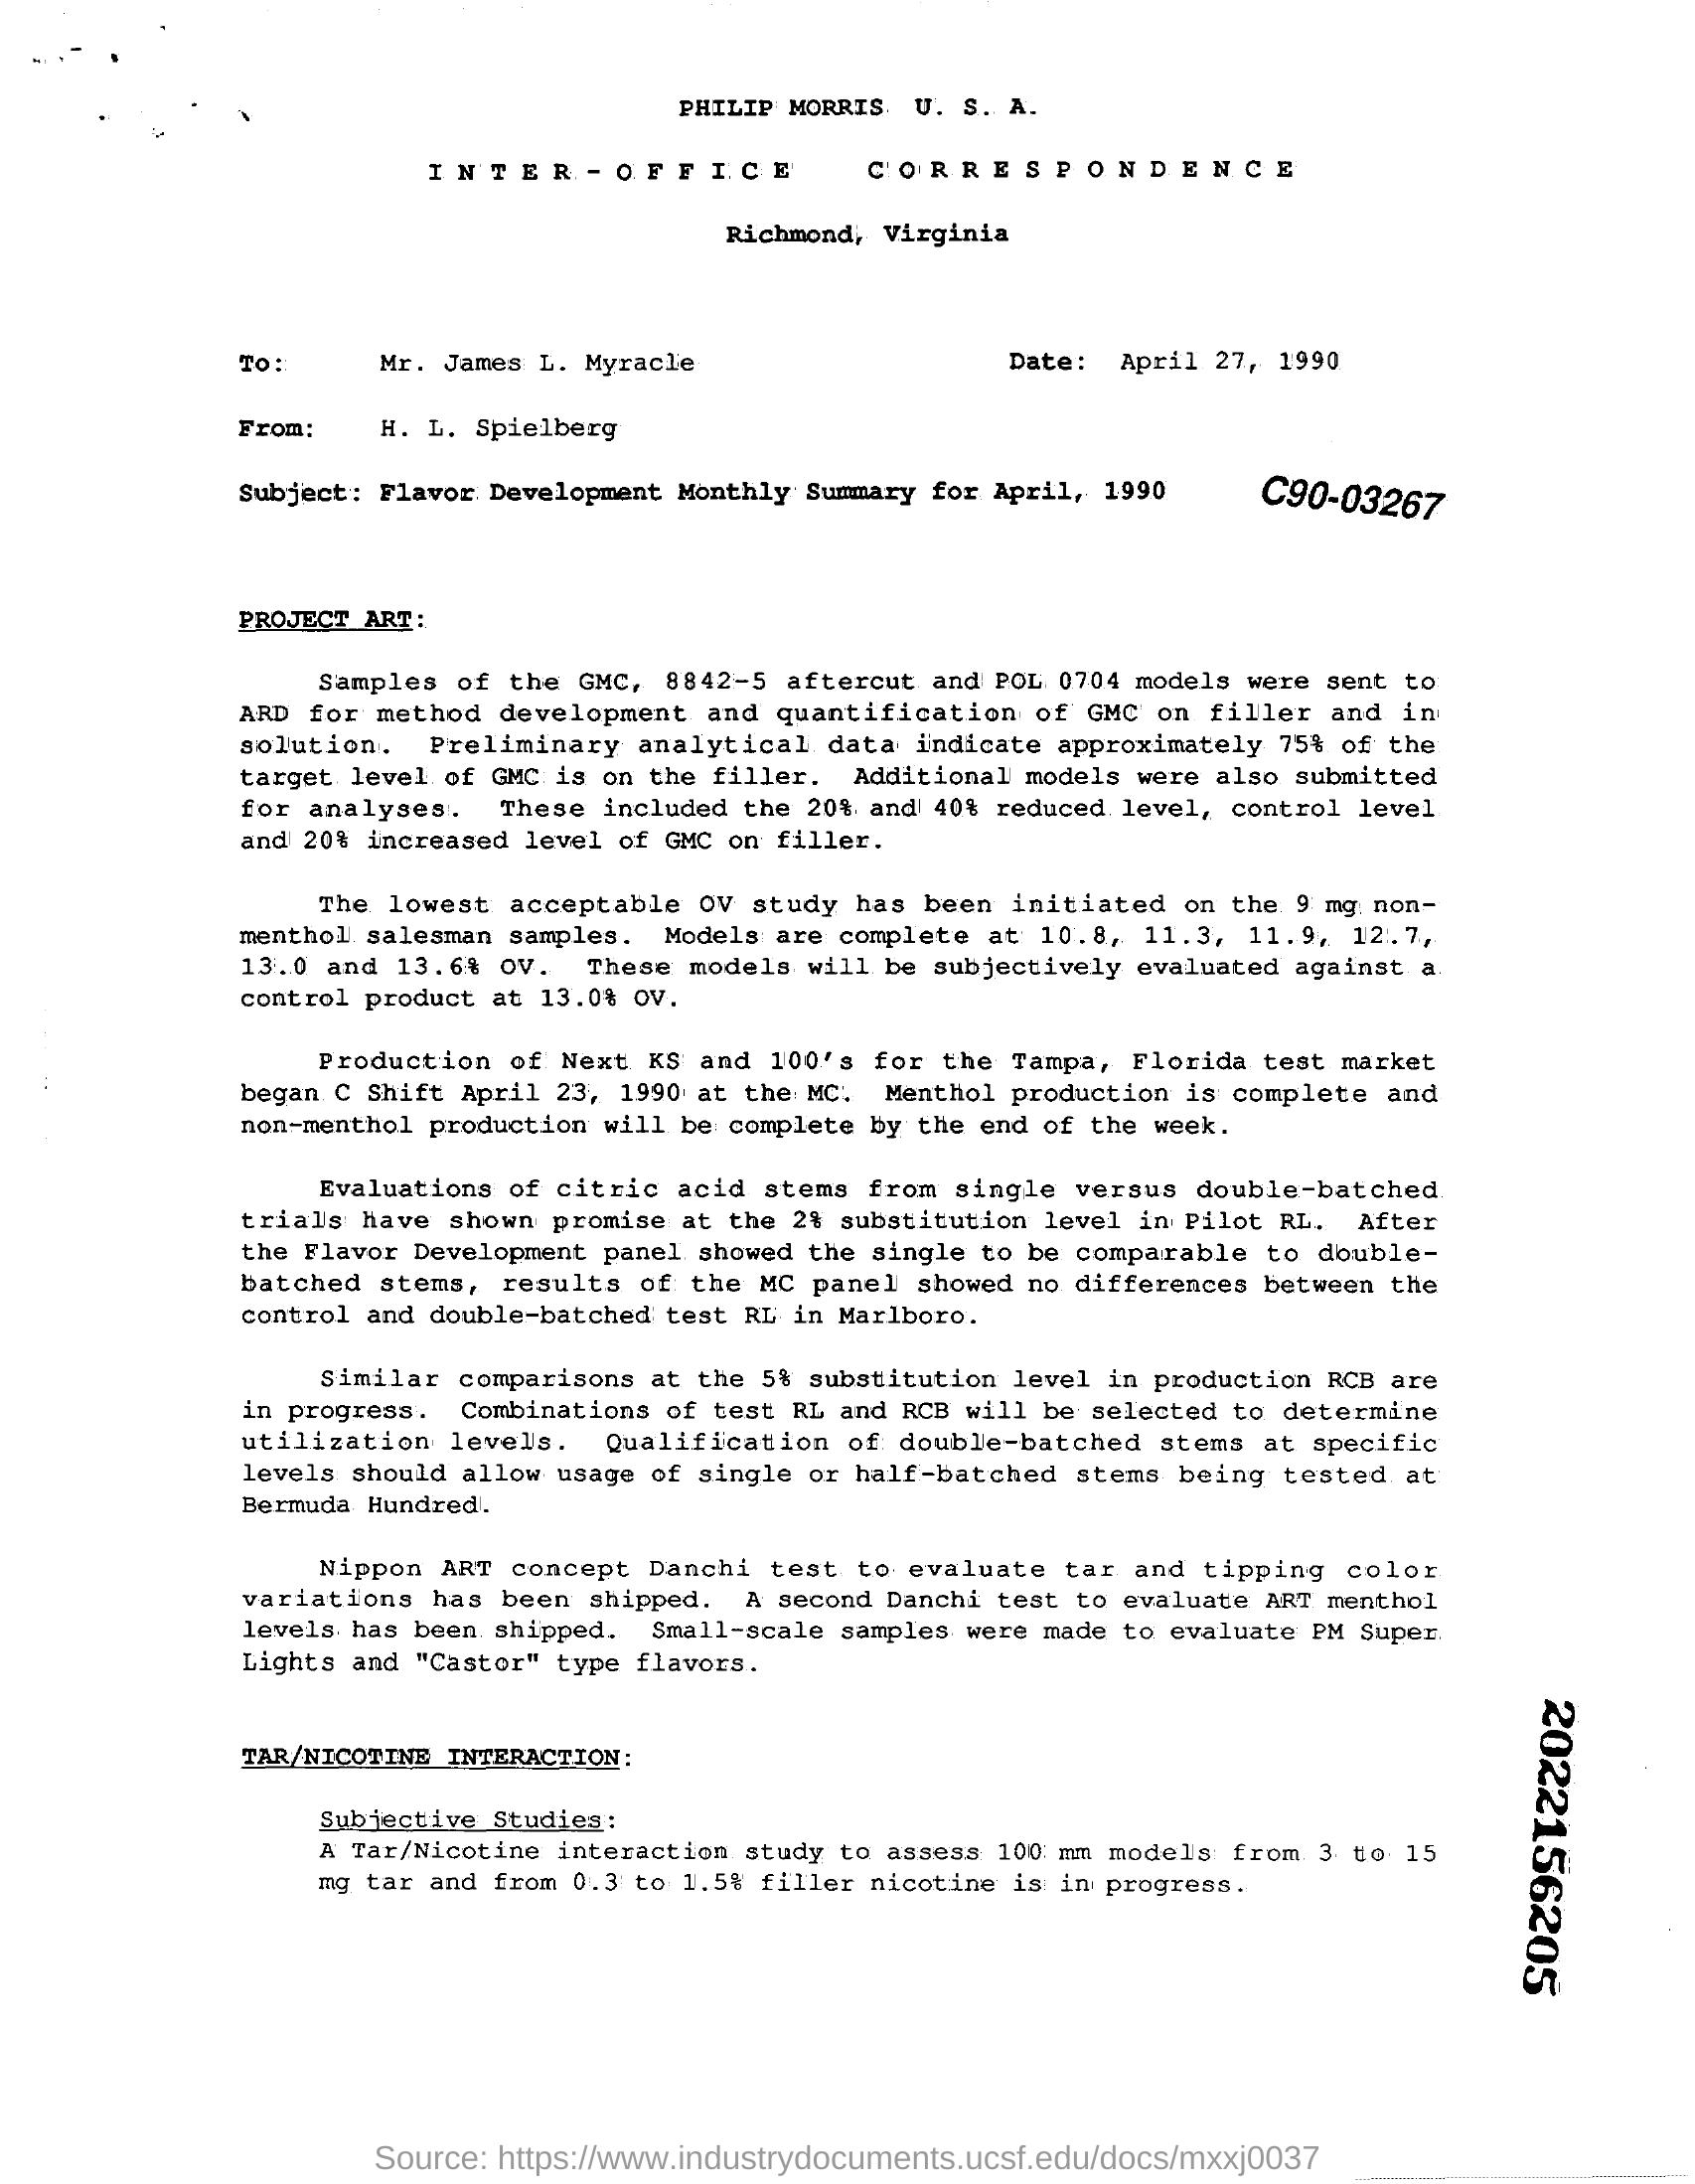

In [ ]:
updated_dataset["train"][11]["image"]

## Предварительная обработка данных

Задача ответов на вопросы по документу является мультимодальной задачей, и вам необходимо убедиться, что входные данные каждой модальности
предварительно обрабатываются в соответствии с ожиданиями модели. Начнем с загрузки [LayoutLMv2Processor](https://huggingface.co/docs/transformers/main/en/model_doc/layoutlmv2#transformers.LayoutLMv2Processor), который внутри объединяет процессор изображений, который может обрабатывать данные изображения, и токенизатор, который может кодировать текстовые данные.

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_checkpoint)

### Предварительная обработка изображений документов

Для начала подготовим изображения документов для модели с помощью `image_processor` процессора. По умолчанию процессор изображений изменяет размер изображений до 224x224, проверяет правильный порядок цветовых каналов, применяет OCR с tesseract для получения слов и нормализованных ограничивающих рамок (bounding boxes). В этом уроке все эти значения по умолчанию — именно то, что нам нужно. Напишите функцию, которая применяет обработку изображений по умолчанию к батчу изображений и возвращает результаты OCR.

In [ ]:
image_processor = processor.image_processor

def get_ocr_words_and_boxes(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    encoded_inputs = image_processor(images)

    examples["image"] = encoded_inputs.pixel_values
    examples["words"] = encoded_inputs.words
    examples["boxes"] = encoded_inputs.boxes

    return examples

Чтобы быстро применить эту предварительную обработку ко всему набору данных, используйте [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map).

In [ ]:
dataset_with_ocr = updated_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=16)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/190 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
dataset_with_ocr_file_name = os.path.join(root_path, "dataset_with_ocr")

In [ ]:
#dataset_with_ocr.save_to_disk(dataset_with_ocr_file_name)

In [ ]:
dataset_with_ocr = load_from_disk(dataset_with_ocr_file_name)
dataset_with_ocr

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'answer', 'question', 'words', 'boxes'],
        num_rows: 904
    })
    test: Dataset({
        features: ['id', 'image', 'answer', 'question', 'words', 'boxes'],
        num_rows: 190
    })
})

### Визуализация документа из обработаного датасета
Я решил добавить эту функцию для лучшего понимания содержимого обработанного датасета.

In [ ]:
def display_document(dataset, index, split="train"):
    document = dataset[split][index]

    words = document["words"]
    boxes = document["boxes"]
    question = document["question"]
    answer = document["answer"]
    doc_id = document["id"]

    fig, ax = plt.subplots(figsize=(18, 22))

    ax.set_xlim(0, max(box[2] for box in boxes))
    ax.set_ylim(max(box[3] for box in boxes), 0)

    for word, box in zip(words, boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor="gray", facecolor="none")
        ax.add_patch(rect)
        text_x = box[0] + (box[2] - box[0]) / 2
        text_y = box[1] + (box[3] - box[1]) / 2
        plt.text(text_x, text_y, word, color="gray", ha="center", va="center")


    plt.title(f"Документ: {doc_id}\nВопрос: {question}\nОтвет: {answer}")
    plt.show()

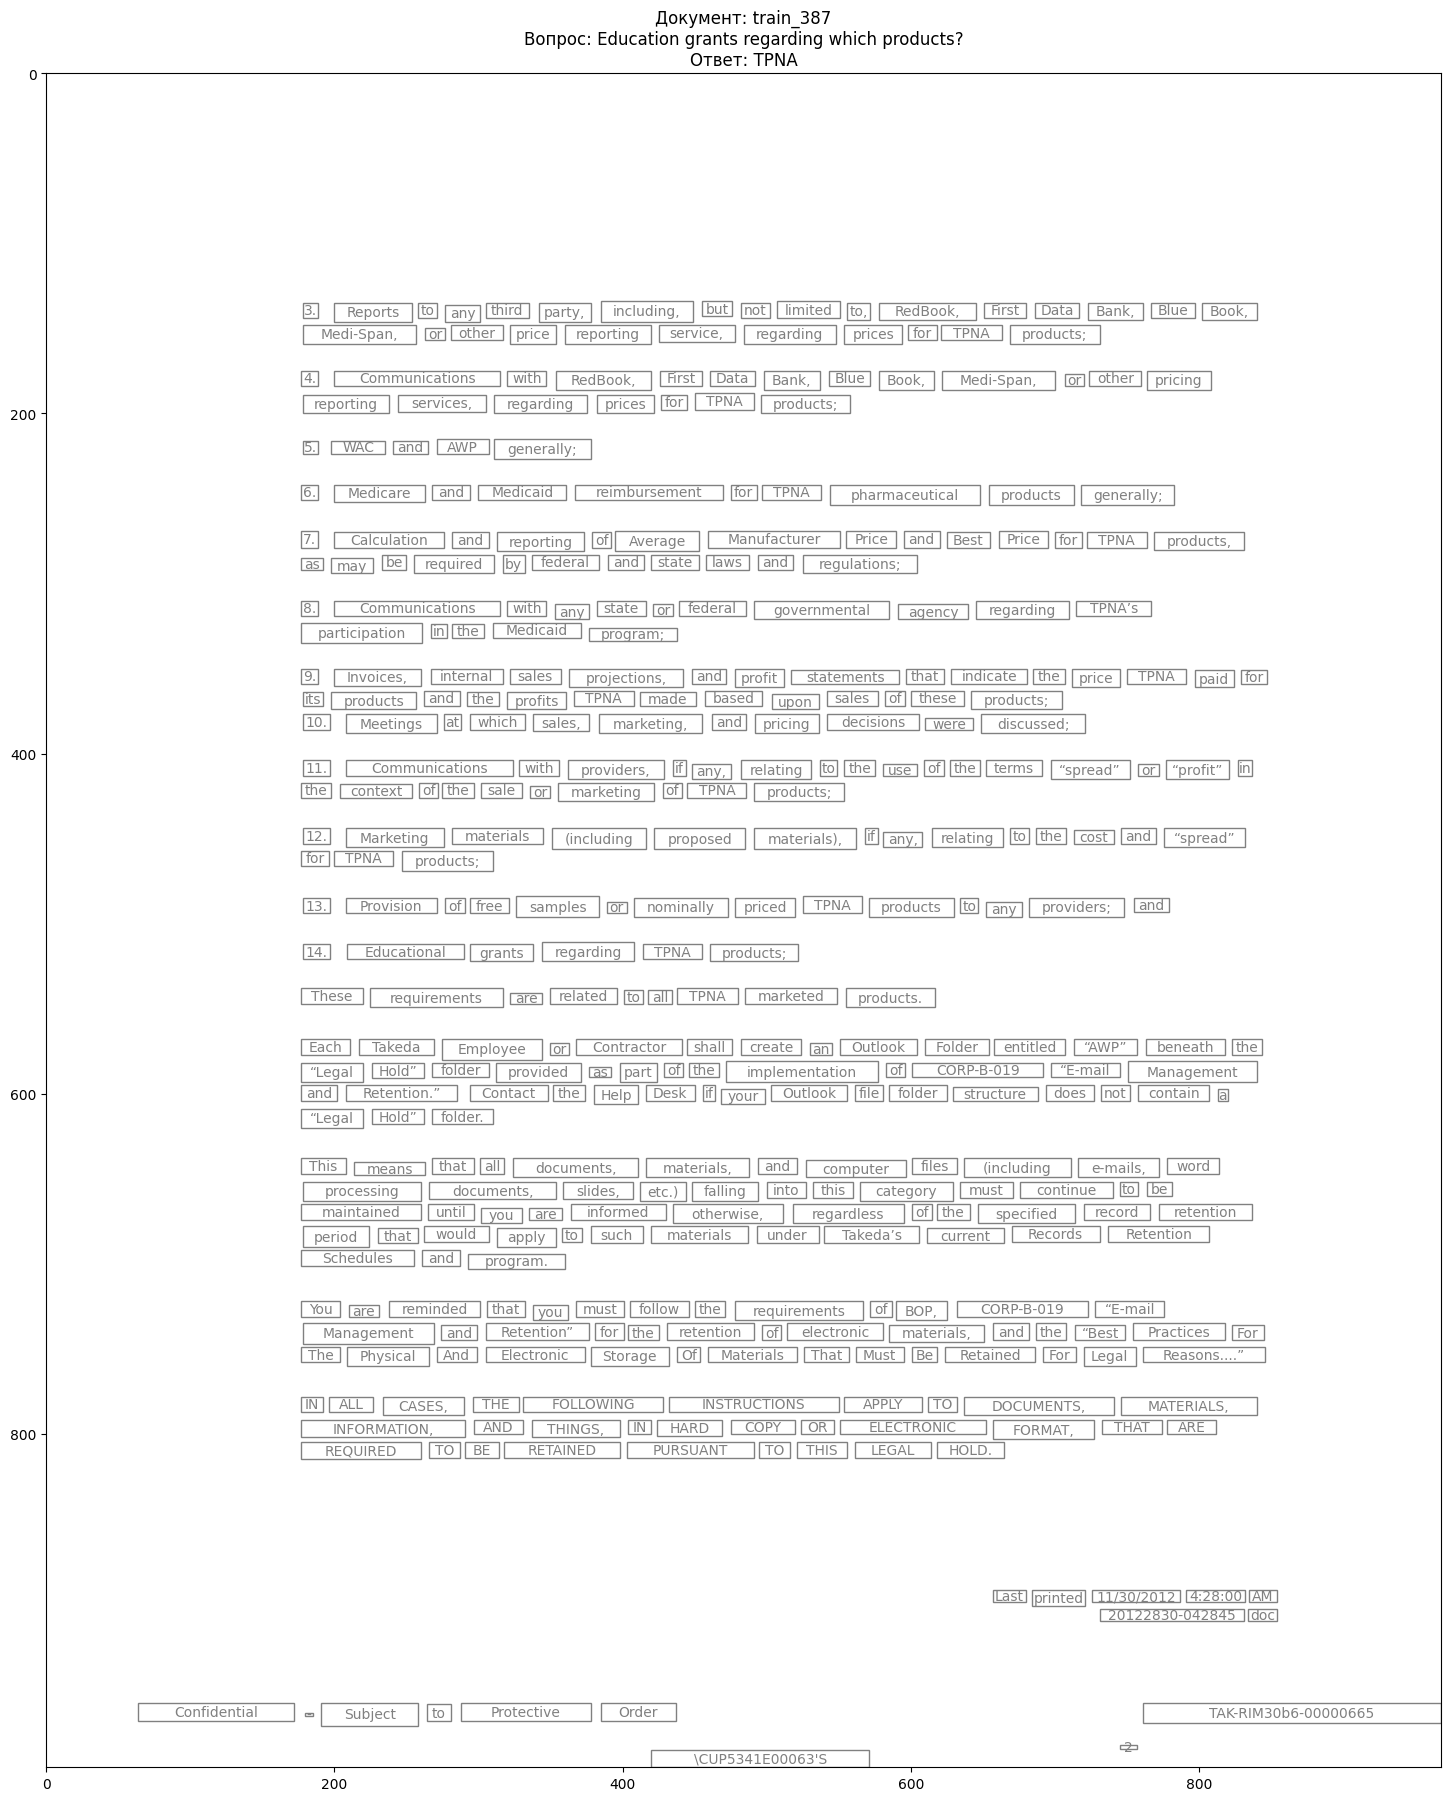

In [ ]:
random_index = random.randint(0, len(dataset_with_ocr['train']) - 1)
display_document(dataset_with_ocr, random_index)

### Предварительная обработка текстовых данных

После того, как мы применили OCR к изображениям, нам нужно закодировать текстовую часть набора данных, чтобы подготовить ее для модели. Это включает в себя преобразование слов и bounding boxes, которые мы получили на предыдущем шаге, в `input_ids`, `attention_mask`, `token_type_ids` и `bbox` уровня токена. Для предварительной обработки текста нам понадобится токенизатор процессора.

In [ ]:
tokenizer = processor.tokenizer

Помимо упомянутой выше предварительной обработки, нам также необходимо добавить метки для модели. Для моделей `xxxForQuestionAnswering` в 🤗 Transformers метки состоят из `start_positions` и `end_positions`, указывающих, какой токен находится в начале, а какой токен — в конце ответа.

Начнем с этого. Определите вспомогательную функцию, которая может найти подсписок (ответ, разделенный на слова) в более крупном списке (списке слов).

Эта функция будет принимать на вход два списка:`words_list` и `answer_list`. Затем он будет перебирать `words_list` и проверять
равно ли текущее слово в `words_list` (words_list[i]) первому слову в (answer_list[0]) и равен ли подсписок `words_list`, начинающийся с текущего слова и той же длины, что и `answer_list` списку `response_list`.
Если это условие истинно, это означает, что совпадение найдено, и функция запишет совпадение, его начальный индекс (idx) и конечный индекс (idx + len(answer_list) - 1). Если найдено более одного совпадения, функция вернет только первое.
Если совпадение не найдено, функция возвращает (`None`, 0, и 0).

In [12]:
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i : i + len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
        return matches[0], start_indices[0], end_indices[0]
    else:
        return None, 0, 0

Чтобы проиллюстрировать, как эта функция находит позицию ответа, давайте воспользуемся ею на примере:

In [ ]:
example = dataset_with_ocr["train"][1]
words = [word.lower() for word in example["words"]]
match, word_idx_start, word_idx_end = subfinder(words, example["answer"].lower().split())
print("Question: ", example["question"])
print("Words:", words)
print("Answer: ", example["answer"])
print("start_index", word_idx_start)
print("end_index", word_idx_end)

Question:  Who is in  cc in this letter?
Words: ['wie', 'baw', 'brown', '&', 'williamson', 'tobacco', 'corporation', 'research', '&', 'development', 'internal', 'correspondence', 'to:', 'r.', 'h.', 'honeycutt', 'ce:', 't.f.', 'riehl', 'from:', '.', 'c.j.', 'cook', 'date:', 'may', '8,', '1995', 'subject:', 'review', 'of', 'existing', 'brainstorming', 'ideas/483', 'the', 'major', 'function', 'of', 'the', 'product', 'innovation', 'graup', 'is', 'to', 'develop', 'marketable', 'nove!', 'products', 'that', 'would', 'be', 'profitable', 'to', 'manufacture', 'and', 'sell.', 'novel', 'is', 'defined', 'as:', 'of', 'a', 'new', 'kind,', 'or', 'different', 'from', 'anything', 'seen', 'or', 'known', 'before.', 'innovation', 'is', 'defined', 'as:', 'something', 'new', 'or', 'different', 'introduced;', 'act', 'of', 'innovating;', 'introduction', 'of', 'new', 'things', 'or', 'methods.', 'the', 'products', 'may', 'incorporate', 'the', 'latest', 'technologies,', 'materials', 'and', 'know-how', 'available'

Однако после кодирования примеров они будут выглядеть так:

In [ ]:
encoding = tokenizer(example["question"], example["words"], example["boxes"])
tokenizer.decode(encoding["input_ids"])

'[CLS] who is in cc in this letter? [SEP] wie baw brown & williamson tobacco corporation research & development internal correspondence to : r. h. honeycutt ce : t. f. riehl from :. c. j. cook date : may 8, 1995 subject : review of existing brainstorming ideas / 483 the major function of the product innovation graup is to develop marketable nove! products that would be profitable to manufacture and sell. novel is defined as : of a new kind, or different from anything seen or known before. innovation is defined as : something new or different introduced ; act of innovating ; introduction of new things or methods. the products may incorporate the latest technologies, materials and know - how available to give then a unique taste or look. the first task of the product innovation group was to assemble, review and categorize a list of existing brainstorming ideas. ideas were grouped into two major categories labeled appearance and taste / aroma. these categories are used for novel products 

Нам нужно будет найти позицию ответа в закодированном вводе.
* `token_type_ids` сообщает нам, какие токены являются частью вопроса, а какие — частью слов документа.
* `tokenizer.cls_token_id` поможет найти специальный токен в начале ввода.
* `word_ids` поможет сопоставить ответ, найденный в исходных `words`, с тем же ответом в полностью закодированных входных данных и определить начальную/конечную позицию ответа в закодированном вводе.

Имея это в виду, давайте создадим функцию для кодирования батча примеров в наборе данных:

In [ ]:
def encode_dataset(examples, max_length=512):
    questions = examples["question"]
    words = examples["words"]
    boxes = examples["boxes"]
    answers = examples["answer"]

    # encode the batch of examples and initialize the start_positions and end_positions
    encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)
    start_positions = []
    end_positions = []

    # loop through the examples in the batch
    for i in range(len(questions)):
        cls_index = encoding["input_ids"][i].index(tokenizer.cls_token_id)

        # find the position of the answer in example's words
        words_example = [word.lower() for word in words[i]]
        answer = answers[i]
        match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())

        if match:
            # if match is found, use `token_type_ids` to find where words start in the encoding
            token_type_ids = encoding["token_type_ids"][i]
            token_start_index = 0
            while token_type_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(encoding["input_ids"][i]) - 1
            while token_type_ids[token_end_index] != 1:
                token_end_index -= 1

            word_ids = encoding.word_ids(i)[token_start_index : token_end_index + 1]
            start_position = cls_index
            end_position = cls_index

            # loop over word_ids and increase `token_start_index` until it matches the answer position in words
            # once it matches, save the `token_start_index` as the `start_position` of the answer in the encoding
            for id in word_ids:
                if id == word_idx_start:
                    start_position = token_start_index
                else:
                    token_start_index += 1

            # similarly loop over `word_ids` starting from the end to find the `end_position` of the answer
            for id in word_ids[::-1]:
                if id == word_idx_end:
                    end_position = token_end_index
                else:
                    token_end_index -= 1

            start_positions.append(start_position)
            end_positions.append(end_position)

        else:
            start_positions.append(cls_index)
            end_positions.append(cls_index)

    encoding["image"] = examples["image"]
    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions

    return encoding

Теперь, когда у нас есть функция предварительной обработки, мы можем закодировать весь набор данных:

In [ ]:
encoded_train_dataset = dataset_with_ocr["train"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["train"].column_names
)
encoded_test_dataset = dataset_with_ocr["test"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["test"].column_names
)

Давайте проверим, как выглядят признаки закодированного набора данных:

In [ ]:
encoded_train_dataset.features

{'image': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='uint8', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'start_positions': Value(dtype='int64', id=None),
 'end_positions': Value(dtype='int64', id=None)}

## Обучение

Поздравляем! Вы успешно прошли самую сложную часть этого руководства и теперь готовы обучать свою собственную модель.
Обучение включает в себя следующие этапы:
* Загрузите модель с помощью [AutoModelForDocumentQuestionAnswering](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForDocumentQuestionAnswering), используя тот же чекпоинт, что и при предварительной обработке.
* Определите гиперпараметры обучения в [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
* Определите функцию для обработки батчей примеров, здесь [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator) вполне подойдет.
* Передайте аргументы обучения [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) вместе с моделью, набором данных и средством сборки данных.
* Вызовите [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train), чтобы тонко настроить вашу модель.

In [ ]:
from transformers import AutoModelForDocumentQuestionAnswering

model = AutoModelForDocumentQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['layoutlmv2.visual_segment_embedding', 'qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


В [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) используйте `output_dir`, чтобы указать, где сохранить вашу модель, и настройте гиперпараметры по своему усмотрению.
Если вы хотите поделиться своей моделью с сообществом, установите для параметра `push_to_hub` значение `True` (вы должны войти в Hugging Face, чтобы загрузить свою модель).
В этом случае `output_dir` также будет именем репозитория, куда будет помещен чекпоинт вашей модели.

In [ ]:
from transformers import TrainingArguments

repo_id = "MariaK/layoutlmv2-base-uncased_finetuned_docvqa"

training_args = TrainingArguments(
    output_dir=os.path.join(root_path, repo_id), # Сохраняем на Google Drive
    logging_dir=os.path.join(root_path, "logs"),
    num_train_epochs=15,
    save_total_limit=2, # Для экономии дискового пространства
    save_steps=200,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-5,
    remove_unused_columns=False,
    push_to_hub=False, # Не отправляем на хаб
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    greater_is_better=True,
    metric_for_best_model="f1",
    do_train=True,
    do_eval=True,
)

### Расчет метрик и оценка во время обучения

Для расчета была взята "squad_v2" из evaluate, потому как обычная "squad" неадекватно рассчитывала F1 для случаев с пустым предсказанием и пустым референсом (выдавала 0), см. исходный код, ошибочный расчет возникает на строчке "num_same = sum(common.values())" : https://github.com/huggingface/evaluate/blob/main/metrics/squad/compute_score.py

In [ ]:
def get_answer(tokenizer, encoded_dataset, index, start_position, end_position):
    encoding = encoded_dataset[index]
    answer_tokens = encoding["input_ids"][start_position:end_position + 1]
    answer = tokenizer.decode(answer_tokens) #, skip_special_tokens=True)

    return answer

In [ ]:
def get_predictions(tokenizer, encoded_dataset, start_positions, end_positions):
    predictions = []
    for index in range(len(encoded_dataset)):
        answer = get_answer(tokenizer, encoded_dataset, index, start_positions[index], end_positions[index])
        predictions.append({"id": str(index), "prediction_text": answer, "no_answer_probability": 0.0})

    return predictions

In [ ]:
def get_references(tokenizer, encoded_dataset, start_positions, end_positions):
    references = []
    for index in range(len(encoded_dataset)):
        answer = get_answer(tokenizer, encoded_dataset, index, start_positions[index], end_positions[index])
        references.append({"id": str(index), "answers": {"text": [answer], "answer_start": [start_positions[index]]}})

    return references

In [ ]:
def compute_metrics(p):
    start_logits, end_logits = p.predictions
    predictions = get_predictions(tokenizer, encoded_test_dataset, np.argmax(start_logits, axis=-1), np.argmax(end_logits, axis=-1))
    references = get_references(tokenizer, encoded_test_dataset, p.label_ids[0], p.label_ids[1])
    metrics = metric.compute(predictions=predictions, references=references)
    result = {"exact": metrics["exact"] / 100.0, "f1": metrics["f1"] / 100.0}

    return result

### Запуск обучения

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
#del model
torch.cuda.empty_cache()

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Exact,F1
100,4.676400,3.910810,0.052632,0.119294
200,3.639300,3.460725,0.105263,0.168230
300,3.065200,3.217124,0.168421,0.198308
400,2.461200,2.776539,0.305263,0.359618
500,1.963300,2.788241,0.378947,0.409409
600,1.542500,2.309991,0.394737,0.443464
700,1.236100,2.542086,0.400000,0.439502
800,1.012900,2.584722,0.489474,0.525081
900,0.795700,2.678860,0.484211,0.514728
1000,0.630300,2.902855,0.526316,0.559094


Step,Training Loss,Validation Loss,Exact,F1
100,4.676400,3.910810,0.052632,0.119294
200,3.639300,3.460725,0.105263,0.168230
300,3.065200,3.217124,0.168421,0.198308
400,2.461200,2.776539,0.305263,0.359618
500,1.963300,2.788241,0.378947,0.409409
600,1.542500,2.309991,0.394737,0.443464
700,1.236100,2.542086,0.400000,0.439502
800,1.012900,2.584722,0.489474,0.525081
900,0.795700,2.678860,0.484211,0.514728
1000,0.630300,2.902855,0.526316,0.559094


TrainOutput(global_step=1695, training_loss=1.3903345012383475, metrics={'train_runtime': 4645.5537, 'train_samples_per_second': 2.919, 'train_steps_per_second': 0.365, 'total_flos': 7320029922017280.0, 'train_loss': 1.3903345012383475, 'epoch': 15.0})

In [9]:
best_model_path = os.path.join(root_path, f"best_model_15")

In [ ]:
best_model_path

'/content/drive/My Drive/MIPT/ML Models/HW3/best_model_15'

In [ ]:
#!cd "/content/drive/My Drive/MIPT/ML Models/HW3/" && zip -r "best_model_15.zip" "best_model_15/"

In [ ]:
#trainer.save_model(best_model_path)
#trainer.tokenizer.save_pretrained(best_model_path)
#processor.save_pretrained(best_model_path)

# Результаты

In [10]:
from transformers import pipeline
qa_pipeline = pipeline("document-question-answering", model=best_model_path, device="cuda")

In [ ]:
def display_qa(dataset, qa_pipeline, document_index):
    example = dataset[document_index]
    question = example["query"]["en"]
    answer = example["answers"][0]
    image = example["image"]

    prediction = qa_pipeline(image, question)[0]

    print(f"Вопрос: {question}")
    print(f"Эталонный ответ: {answer}")
    print(f"Предсказанный ответ: {prediction['answer']} ({prediction['score']})\n")

In [ ]:
for document_index in [2, 12, 25]:
    display_qa(dataset["test"], qa_pipeline, document_index)
    print("")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Вопрос: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?
Эталонный ответ: TRRF Vice President
Предсказанный ответ: Lee A. Waller (0.7763035297393799)




/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Вопрос: What is the name of the Dealer ?
Эталонный ответ: A. C. Monk
Предсказанный ответ: Monk (0.04129120707511902)




/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Вопрос: How many 'energetic and popular brands' has ITC created?
Эталонный ответ: 50
Предсказанный ответ: 50 (0.19268956780433655)




### Оценка финального инференса

In [ ]:
def get_predictions_and_references(dataset, pipeline):
    predictions = []
    references = []

    #for index in tqdm([2, 12, 25], desc="Получаем предсказания"):
    for index in tqdm(range(len(dataset)), desc="Получаем предсказания"):
        example = dataset[index]
        question = example["query"]["en"]
        answer = example["answers"][0]
        image = example["image"]

        prediction_result = pipeline(image, question)
        predicted_answer = prediction_result[0]["answer"] if prediction_result else ""

        predictions.append({
            "id": str(index),
            "prediction_text": predicted_answer,
            "no_answer_probability": 0.0
        })
        references.append({
            "id": str(index),
            "answers": {
                "text": [answer],
                "answer_start": [example["answer"]["start"]]
            }
        })

    return predictions, references


In [ ]:
predictions, references = get_predictions_and_references(dataset["test"], qa_pipeline)

Получаем предсказания:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentiall

In [ ]:
def save_to_json(predictions, references, filename):
    data_to_save = {
        "predictions": predictions,
        "references": references
    }
    with open(filename, 'w') as outfile:
        json.dump(data_to_save, outfile, indent=4)

save_to_json(predictions, references, os.path.join(root_path, 'predictions_and_references.json'))

In [ ]:
metrics = metric.compute(predictions=predictions, references=references)

In [ ]:
metrics

{'exact': 32.5,
 'f1': 39.98257575757576,
 'total': 200,
 'HasAns_exact': 32.5,
 'HasAns_f1': 39.98257575757576,
 'HasAns_total': 200,
 'best_exact': 32.5,
 'best_exact_thresh': 0.0,
 'best_f1': 39.98257575757576,
 'best_f1_thresh': 0.0}

# Выводы

Хотелось бы отметить несоответствие метрик F1 и EM на стадии обучения и на стадии финального инференса: несмотря на то что для расчета используется одна и та же библиотека от HuggingFace, на стадии обучения EM = 0.531579 и F1 =	0.565789, но при этом в финальном инференесе с той же моделью я получаю EM = 0.325 и F1 = 0.3998. \
Скорее всего это происходит из-за предобработки, которая вносит изменения в датасет перед обучением:
- Выкидываются 10 записей (200 против 190)
- Делается проверка и перезапись начального и конечного индексов ответа функцией subfinder

Для проверки правильности расчета метрик во время обучения я делал дамп приходящих в compute_metrics данных (через pickle) и после проверял все "руками" - после декодирования данных метрики получались именно такими как в выводе trainer'a.

Как это можно попробовать исправить: написать общую функцию предобработки текста, которая бы использовалась как на стадии формирования датасета для обучения, так и на стадии подсчета метрик из финального инференса.